Author: Sungduk Yu\
Date: Sun 04 Jun 2023 02:40:37 PM PDT\
Description:\
This script calculates evaluation three metrics (MAE, R2, RMSE) based on daily-mean, horizontal-mean values of each variables.\

Input:
 - model_name: a string, model name
 - fn_x_true: npy file name for true input
 - fn_y_true: npy file name for true output
 - fn_y_pred: npy file name for model prediction
 - fn_grid: netcdif file name for grid information
 - fn_mli_mean, fn_mli_min, fn_mli_max: netcdf file names for input normalization coefficients (mean, min, max)
 - fn_mlo_scale: netcdf file name for output scaling coefficients.

Output:
- calculated metrics as csv file "<model_name>.evaluation-metrics.csv"

# Change file names [user input here only!]

In [1]:
# model name
# (model name is used for the output
model_name = 'MLP'
# input of validation dataset (npy)
fn_x_true = '../../npy_data_conversion/npy_files/val_input_stride6.npy'
# true output of validation dataset (npy)
fn_y_true = '../../npy_data_conversion/npy_files/val_target_stride6.npy'
# Model predicted output of varlidation dataset (npy)
fn_y_pred = '../../HPO/baseline_v1/step3_prediction/predicted/'+\
           '001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'
# model grid information (nc)
fn_grid = '../../misc/E3SM-MMF_ne4_grid-info.nc'
# normalization scale factors (nc)
fn_mli_mean  = '../../norm_factors/mli_mean.nc'
fn_mli_min   = '../../norm_factors/mli_min.nc'
fn_mli_max   = '../../norm_factors/mli_max.nc'
fn_mlo_scale = '../../norm_factors/mlo_scale.nc'

# Set energy conversion scale factors

Energy unit conversion
 - "dT/dt" [K/s] * cp [J/kg/K] * dp/g [kg/m2]   -> [W/m2]
 - "dQ/dt" [kg/kg/s] * lv [J/kg] * dp/g [kg/m2] -> [W/m2]
 - "PRECC" [m/s] * lv [J/kg]  * rho_h2o [kg/m3] -> [W/m2] 
 
(for dT/dt and dQ/dt, it should be "dp/g-weighted" vertical integration, not vertical averaging.)

In [2]:
# physical constatns from (E3SM_ROOT/share/util/shr_const_mod.F90)
grav    = 9.80616    # acceleration of gravity ~ m/s^2
cp      = 1.00464e3  # specific heat of dry air   ~ J/kg/K
lv      = 2.501e6    # latent heat of evaporation ~ J/kg
lf      = 3.337e5    # latent heat of fusion      ~ J/kg
ls      = lv + lf    # latent heat of sublimation ~ J/kg
rho_air = 101325./ (6.02214e26*1.38065e-23/28.966) / 273.15 # density of dry air at STP  ~ kg/m^3
                                                            # ~ 1.2923182846924677
                                                            # SHR_CONST_PSTD/(SHR_CONST_RDAIR*SHR_CONST_TKFRZ)
                                                            # SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR 
                                                            # SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
rho_h20 = 1.e3       # density of fresh water     ~ kg/m^ 3

vars_mlo_energy_conv = {'ptend_t':cp,
                        'ptend_q0001':lv,
                        'cam_out_NETSW':1.,
                        'cam_out_FLWDS':1.,
                        'cam_out_PRECSC':lv*rho_h20,
                        'cam_out_PRECC':lv*rho_h20,
                        'cam_out_SOLS':1.,
                        'cam_out_SOLL':1.,
                        'cam_out_SOLSD':1.,
                        'cam_out_SOLLD':1.
                       }
# Vertical weighting (dp/g) is done in the main script as "dp" is not constant throughout samples.

# Main

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# set dimemsion names for xarray datasets
dim_name_level  = 'lev'
dim_name_sample = 'sample'

In [41]:
# load input dataset
x_true = np.load(fn_x_true).astype(np.float64)
y_true = np.load(fn_y_true).astype(np.float64)
y_pred = np.load(fn_y_pred).astype(np.float64)
N_samples = y_pred.shape[0] 

# load norm/scale factors
mlo_scale = xr.open_dataset(fn_mlo_scale)
mli_mean  = xr.open_dataset(fn_mli_mean)
mli_min   = xr.open_dataset(fn_mli_min)
mli_max   = xr.open_dataset(fn_mli_max)

In [5]:
# load grid information
ds_grid = xr.open_dataset(fn_grid) # has ncol:384
N_ncol = len(ds_grid['ncol']) # length of ncol dimension (nlat * nlon)

# make area-weights
ds_grid['area_wgt'] = ds_grid['area'] / ds_grid['area'].sum('ncol')

# map ds_grid's ncol dimension -> the N_samples dimension of npy-loayd arrays (e.g., y_pred)
to_xarray = {'area'    : (dim_name_sample,np.tile(ds_grid['area'],     int(N_samples/len(ds_grid['ncol'])))),
             'area_wgt': (dim_name_sample,np.tile(ds_grid['area_wgt'], int(N_samples/len(ds_grid['ncol'])))),
             'lat':  (dim_name_sample,np.tile(ds_grid['lat'], int(N_samples/len(ds_grid['ncol'])))),
             'lon':  (dim_name_sample,np.tile(ds_grid['lon'], int(N_samples/len(ds_grid['ncol'])))),
            }
to_xarray = xr.Dataset(to_xarray)

# add nsample-mapped grid variables back to ds_grid
ds_grid = xr.merge([ds_grid  [['P0', 'hyai', 'hyam','hybi','hybm']], 
                    to_xarray[['area', 'area_wgt', 'lat', 'lon']]])

## Pack np arrays to xarray dataset

In [6]:
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC',
            'cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD'] # mlo mean ML output.
vars_mlo_len = {'ptend_t':60,
                'ptend_q0001':60,
                'cam_out_NETSW':1,
                'cam_out_FLWDS':1,
                'cam_out_PRECSC':1,
                'cam_out_PRECC':1,
                'cam_out_SOLS':1,
                'cam_out_SOLL':1,
                'cam_out_SOLSD':1,
                'cam_out_SOLLD':1
               }
len_to_dim = {60:dim_name_level,
              N_samples: dim_name_sample}

In [7]:
DS = {}

for kds in ['true', 'pred']:
    if kds=='true':
        work = y_true
    elif kds=='pred':
        work = y_pred
    
    # [1] Construct dictionary for xarray dataset
    #     format is key for variable name / 
    #               value for a turple of (dimension names, data).
    to_xarray = {} 
    for k, kvar in enumerate(vars_mlo):

        # length of variable (ie, number of levels)
        kvar_len = vars_mlo_len[kvar]

        # set dimensions of variable
        if kvar_len == 60:
            kvar_dims = (dim_name_sample, dim_name_level)
        elif kvar_len == 1:
            kvar_dims = dim_name_sample

        # set start and end indices of variable in the loaded numpy array
        # then, add 'kvar':(kvar_dims, <np_array>) to dictionary
        if k==0: ind1=0
        ind2 = ind1 + kvar_len
        
        # scaled output
        kvar_data = np.squeeze(work[:,ind1:ind2])
        # unscaled output
        kvar_data = kvar_data / mlo_scale[kvar].values
        
        to_xarray[kvar] = (kvar_dims, kvar_data)
        
        ind1 = ind2
        
    # [2] convert dict to xarray dataset
    DS[kds] = xr.Dataset(to_xarray)
        
    # [3] add surface pressure ('state_ps') from ml input
    # normalized ps
    state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
    # unnormalized ps
    state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']
    DS[kds]['state_ps'] = state_ps
    
    # [4] add grid information
    DS[kds] = xr.merge([DS[kds], ds_grid])
    
    # [5] add pressure thickness of each level, dp
    tmp = DS[kds]['P0']*DS[kds]['hyai'] + DS[kds]['state_ps']*DS[kds]['hybi']
    tmp = tmp.isel(ilev=slice(1,61)).values - tmp.isel(ilev=slice(0,60)).values
    tmp = tmp.transpose()
    DS[kds]['dp'] = xr.DataArray(tmp, dims=('sample', 'lev'))

del work, to_xarray, y_true, y_pred, x_true, state_ps, tmp

In [8]:
DS[kds]

<xarray.Dataset>
Dimensions:         (sample: 1681920, lev: 60, ilev: 61)
Coordinates:
  * lev             (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev            (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
Dimensions without coordinates: sample
Data variables: (12/21)
    ptend_t         (sample, lev) float64 -1.814e-05 -2.44e-05 ... -3.585e-05
    ptend_q0001     (sample, lev) float64 1.348e-14 1.838e-14 ... 2.872e-09
    cam_out_NETSW   (sample) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 63.74 18.73
    cam_out_FLWDS   (sample) float64 374.6 365.0 413.2 ... 268.0 246.2 288.9
    cam_out_PRECSC  (sample) float64 0.0 0.0 0.0 ... 1.844e-08 1.958e-09
    cam_out_PRECC   (sample) float64 0.0 1.276e-09 5.25e-09 ... 1.734e-08 0.0
    ...              ...
    hybm            (lev) float64 ...
    area            (sample) float64 0.02745 0.0307 0.0307 ... 0.0307 0.02745
    area_wgt        (sample) float64 0.002184 0.002443 ... 0.002443 0.002184
    lat             (sample) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
    lon             (sample) float64 320.3 331.5 320.4 ... 123.3 146.7 135.0
    dp              (sample, lev) float64 4.493 8.059 ... 1.467e+03 1.489e+03

## 1) Converting variable units to common energy unit [W/m2] and 2) Make a global mean, e.g., X[samples, ncol] to X[samples]

In [33]:
DS_ENERGY = {}
for kds in ['true','pred']:
    # Make a copy to keep original dataset
    DS_ENERGY[kds] = DS[kds].copy(deep=True)    
    
    # [1] Make a daily mean
    # One day = 72 time step.
    # Validation dataset is already sub-sampled with a stride of 6.
    # So, coarsen by 12.
    DS_ENERGY[kds] = DS_ENERGY[kds].coarsen({'sample':12}).mean()
    
    # [2] Make unit conversions for each variable
    for kvar in vars_mlo:
        # [2a] vertically integrate variables that have a 'lev' dim. (e.g., ptend_{t,q0001})
        # dp/g = - \rho * dz
        if vars_mlo_len[kvar] == 60:
            DS_ENERGY[kds][kvar] = DS_ENERGY[kds][kvar] * DS_ENERGY[kds]['dp']/grav
            DS_ENERGY[kds][kvar] = DS_ENERGY[kds][kvar].sum('lev')
            
        # [2b] multipy a coefficient to convert units of ptend_{t,q0001}, precsc, precc to W/m2:
        DS_ENERGY[kds][kvar] =  vars_mlo_energy_conv[kvar] * DS_ENERGY[kds][kvar] 
        
        # Now, all mlo variables has a horizontal dimension.
        # [2c] make a area-weighted average for each variable to make a global mean.
        #      then save it to the new variable name
        DS_ENERGY[kds][kvar] = DS_ENERGY[kds]['area_wgt'] * DS_ENERGY[kds][kvar]
        DS_ENERGY[kds][kvar] = DS_ENERGY[kds][kvar].coarsen(sample=N_ncol).sum().rename({'sample':'sample_global_avg'})
        
    # [3] subset only model output variables
    DS_ENERGY[kds] = DS_ENERGY[kds][vars_mlo]

In [34]:
DS_ENERGY[kds]

<xarray.Dataset>
Dimensions:         (sample_global_avg: 365)
Dimensions without coordinates: sample_global_avg
Data variables:
    ptend_t         (sample_global_avg) float64 -14.16 -13.82 ... -14.13 -14.54
    ptend_q0001     (sample_global_avg) float64 -73.47 -74.51 ... -70.69 -71.1
    cam_out_NETSW   (sample_global_avg) float64 158.5 158.6 ... 163.5 162.8
    cam_out_FLWDS   (sample_global_avg) float64 341.6 341.1 ... 340.7 341.3
    cam_out_PRECSC  (sample_global_avg) float64 7.133 6.98 6.856 ... 7.091 6.696
    cam_out_PRECC   (sample_global_avg) float64 77.19 75.47 76.5 ... 73.72 73.33
    cam_out_SOLS    (sample_global_avg) float64 62.44 62.49 ... 63.83 63.85
    cam_out_SOLL    (sample_global_avg) float64 68.13 68.28 ... 69.46 69.42
    cam_out_SOLSD   (sample_global_avg) float64 34.4 34.47 34.12 ... 36.0 35.93
    cam_out_SOLLD   (sample_global_avg) float64 18.38 18.35 ... 19.43 19.41

## Calculate metrics based on globally-averaged model output

In [35]:
# calculate metrics on (daily-averaged, globally-averaged values)
MAE  = (np.abs(DS_ENERGY['true'] - DS_ENERGY['pred'])).mean()
RMSE = np.sqrt(((DS_ENERGY['true'] - DS_ENERGY['pred'])**2.).mean())
R2 = 1 - ((DS_ENERGY['true'] - DS_ENERGY['pred']       )**2.).sum()/\
         ((DS_ENERGY['true'] - DS_ENERGY['true'].mean())**2.).sum()

In [36]:
# save the output
f_save = f'{model_name}.evaluation-metrics.csv'
work = pd.DataFrame({'MAE':  MAE.to_pandas(), 
                     'RMSE': RMSE.to_pandas(),
                     'R2':   R2.to_pandas()}
                    )
work.index.name = 'Variable'
work.to_csv(f_save)
work

,MAE,RMSE,R2
Variable,,,
ptend_t,2.442297,3.120238,0.712602
ptend_q0001,2.853810,3.516285,0.358400
cam_out_NETSW,1.339263,1.669616,0.897708
cam_out_FLWDS,0.411216,0.529883,0.995739
cam_out_PRECSC,0.421264,0.498826,0.722853
cam_out_PRECC,2.129443,2.717430,0.610800
cam_out_SOLS,1.222218,1.343763,0.727789
cam_out_SOLL,0.960721,1.122832,0.879560
cam_out_SOLSD,0.339855,0.424840,0.946978


# Plot

In [37]:
metrics = pd.read_csv(f_save, index_col=0)

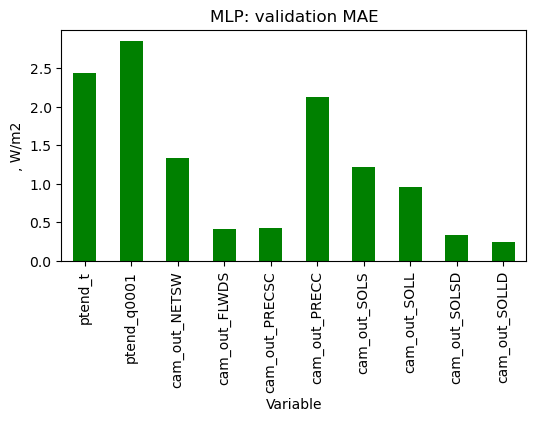

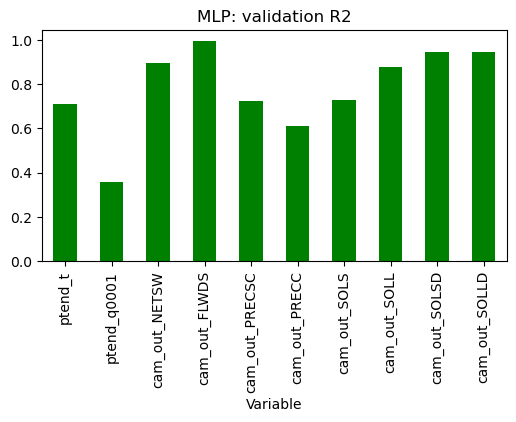

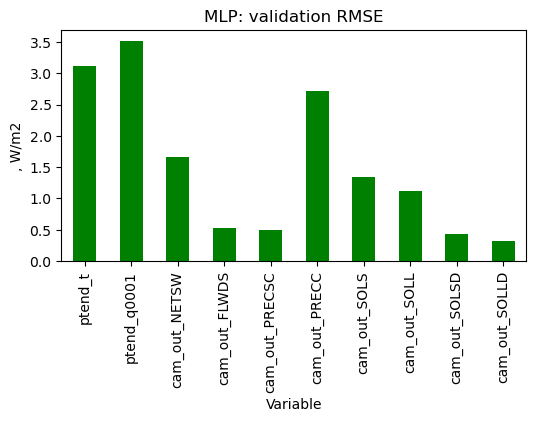

In [38]:
sw_y_scale_log = False

for kmetric in ['MAE', 'R2', 'RMSE']:
    fig, ax = plt.subplots()
    metrics[kmetric].plot.bar(ax=ax, color='green')
    ax.set_ylabel('' if kmetric == 'R2' else ', W/m2')
    ax.set_title(f'{model_name}: validation {kmetric}')
    if sw_y_scale_log: ax.set_yscale('log')
    fig.set_size_inches(6,3)